In [142]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import dataframe_image as dfi
from sklearn import metrics

In [143]:
test = pd.read_csv('../../Data/test.csv')
test_labels = pd.read_csv('../../Data/test_labels.csv')
test_filtered = pd.merge(test, test_labels)
test_filtered = test_filtered.drop(test_filtered.index[test_filtered['toxic'] == -1])

In [144]:
cat = pd.read_csv('../CatBoost/catboost_predictions_raw.csv')
bert = pd.read_csv('../BERT/bert_predictions_raw.csv')
lreg = pd.read_csv('../LogisticRegression/predictions_csv_files/LR_precisions.csv')
cnn = pd.read_csv('../CNN/cnn_pred_raw.csv')
lstm = pd.read_csv('../LSTM_GRU/gru_ft_predictions.csv')

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
models = [cat, bert, lreg]
model_names = ["CatBoost", "BERT", "LogisticReg"]

The ensemble will perform better if the individual models have low correlations with each other.

In [145]:
for label in labels:
    print(label)
    corr = np.corrcoef([x[label] for x in models])
    df = pd.DataFrame(data=corr, 
              index=corr[:, 0],    # first column as index
              columns=model_names)  
    corr = df.corr()
    df_styled = corr.style.background_gradient(cmap='coolwarm')
    display(df_styled)
    dfi.export(df_styled, 'corr_'+label+'.png')

toxic


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.848593,-0.141815
BERT,-0.848593,1.000000,-0.403357
LogisticReg,-0.141815,-0.403357,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


severe_toxic


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.364289,-0.569594
BERT,-0.364289,1.000000,-0.557952
LogisticReg,-0.569594,-0.557952,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


obscene


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.745470,0.060615
BERT,-0.745470,1.000000,-0.710500
LogisticReg,0.060615,-0.710500,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


threat


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.546663,-0.646568
BERT,-0.546663,1.000000,-0.285325
LogisticReg,-0.646568,-0.285325,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


insult


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.727267,-0.334609
BERT,-0.727267,1.000000,-0.403440
LogisticReg,-0.334609,-0.403440,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


identity_hate


,CatBoost,BERT,LogisticReg
CatBoost,1.000000,-0.694901,-0.357928
BERT,-0.694901,1.000000,-0.422739
LogisticReg,-0.357928,-0.422739,1.000000


c:\programmering\KAIST\CS470\env\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [155]:
# Create new predictions based on the other models
preds = models[0].copy()
weights = [0.09, 0.9, 0.01]
for label in labels:
    sum = 0
    for i, x in enumerate(models):
        sum += weights[i] * x[label]
    preds[label] = sum


# Calculate f1-score
avg = 0
for i, label in enumerate(labels):
    print(label, ":")
    pb = preds[label] >= 0.5
    score = f1_score(test_filtered[label], pb)
    print(score)
    avg += score

avg /= len(labels)
print("Average f1-score:", avg)

toxic :
0.6892233915012655
severe_toxic :
0.1855203619909502
obscene :
0.6783559148354775
threat :
0.3123123123123123
insult :
0.6839953271028036
identity_hate :
0.5066666666666667
Average f1-score: 0.5093456624015794


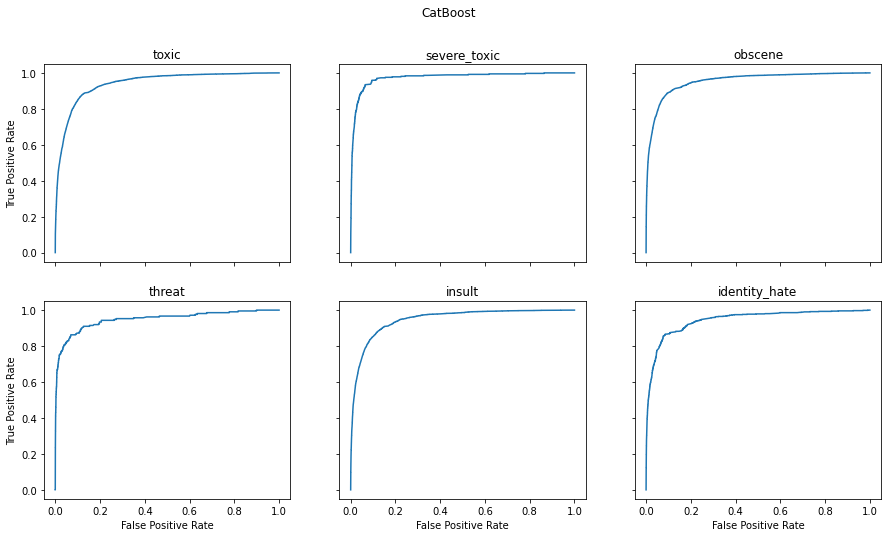

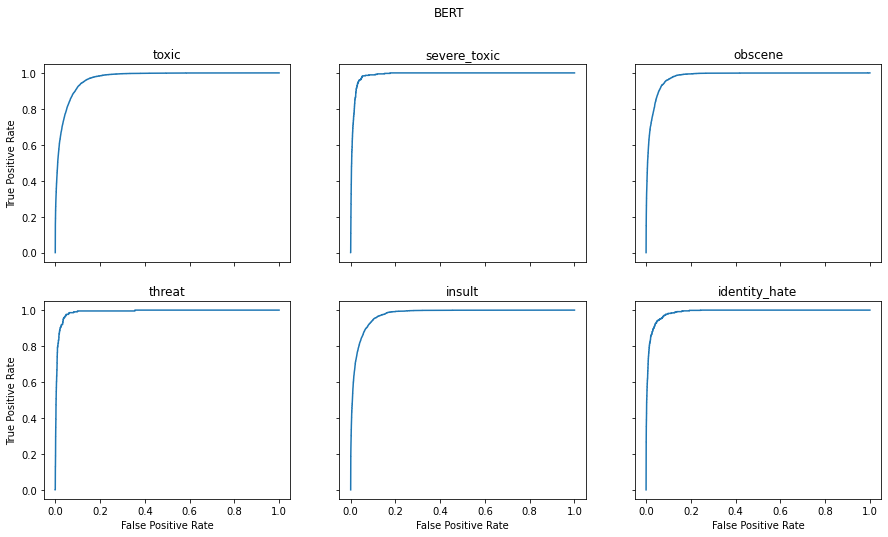

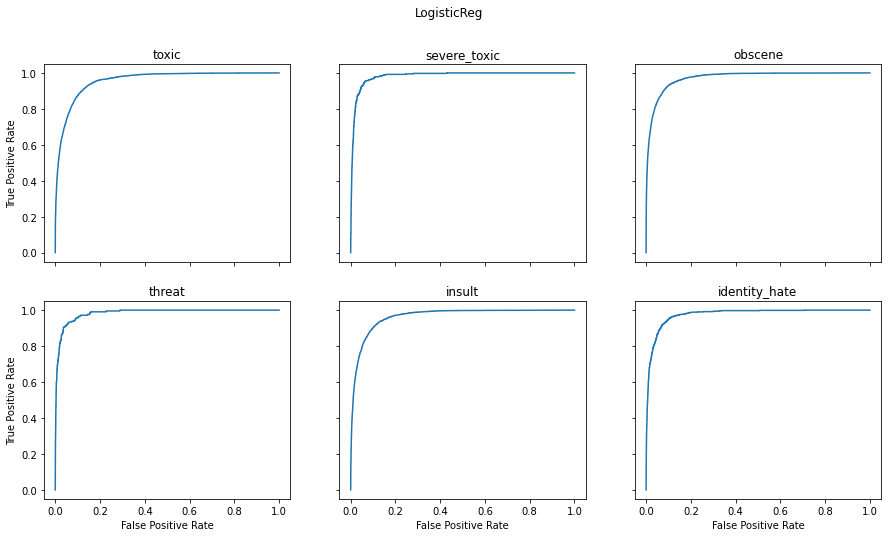

In [147]:
plt.rcParams['figure.figsize'] = [15, 8]
for i, model in enumerate(models):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True) 
    for j, label in enumerate(labels): 
        l = 0
        k = j
        if j > 2: 
            l = 1
            k -= 3      
        fpr, tpr, _ = metrics.roc_curve(test_filtered[label], model[label])
        axs[l, k].plot(fpr,tpr)
        axs[l, k].title.set_text(label)

    fig.suptitle(model_names[i])
    plt.setp(axs[1, :], xlabel='False Positive Rate')
    plt.setp(axs[:, 0], ylabel='True Positive Rate')
    plt.show()